In [3]:
import numpy as np
import random
import os
import keras_tuner as kt
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import GlobalMaxPooling2D, Activation, Dense, Conv1D, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras import optimizers

%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers



from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

from utils.deep import preProcess
from utils.visualize import showMe, showHistory
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
classes = ['Rest','EyeBrow','Chew']

def smoothLabels(label, factor = 0.):
    label *= (1 - factor)
    label += (factor / len(label))
    return label

def oneHot(label, classes = classes):
    label = to_categorical(label,num_classes=len(classes))
    return smoothLabels(label)

def applyOneHot(data):
    new = []
    for y in data:
        new.append(oneHot(y))
    return np.array(new)


In [63]:
signal_length = 100

resource_path = 'resources/'
train_sessions = ['session_0','session_1', 'session_2', 'session_3', 'session_4']
test_sessions  = ['session_0','session_1', 'session_2', 'session_3', 'session_4']

rests = []
eyebrows = []
chews = []
for session in train_sessions:
    rests.append(np.load(os.path.join(resource_path,session,'Rest.npy')))
    eyebrows.append(np.load(os.path.join(resource_path,session,'Eyebrow.npy')))
    chews.append(np.load(os.path.join(resource_path,session,'Chew.npy')))
rests = np.concatenate((rests),axis=0)
eyebrows = np.concatenate((eyebrows),axis=0)
chews = np.concatenate((chews),axis=0)


rests = preProcess(rests, signal_length)
eyebrows = preProcess(eyebrows, signal_length)
chews = preProcess(chews, signal_length)
print(rests.shape)


(100, 6, 100)


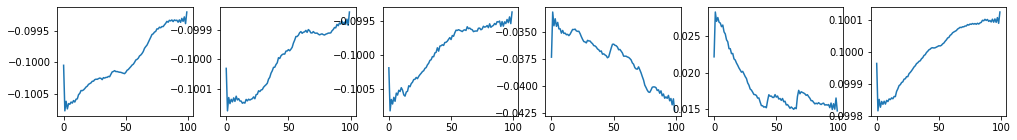

In [87]:
rests_avg = rests.mean(axis=0)
showMe(rests_avg)

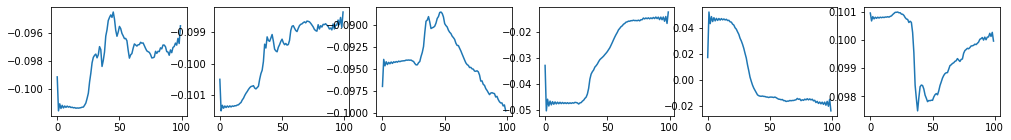

In [85]:
eyebrows_avg = eyebrows.mean(axis=0)
showMe(eyebrows_avg)

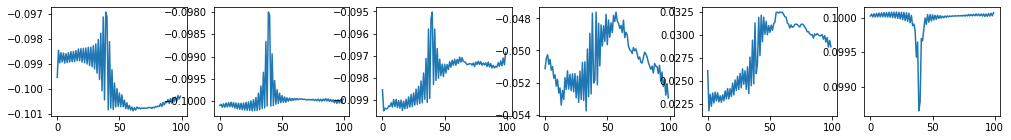

In [86]:
chews_avg = chews.mean(axis=0)
showMe(chews_avg)

In [ ]:
for i in range(5):
    showMe(eyebrows[i])

In [ ]:
for i in range(5):
    showMe(rests[i])

In [64]:
X = np.concatenate((rests,eyebrows,chews),axis = 0)
y = np.concatenate(( np.zeros(rests.shape[0]),np.ones(eyebrows.shape[0]),np.ones(eyebrows.shape[0])*2))


#SHUFFLE DATA
c = list(zip(X, y))
random.shuffle(c)
X,y = zip(*c)
X = np.array(X)
y = np.array(y)

y = applyOneHot(y)


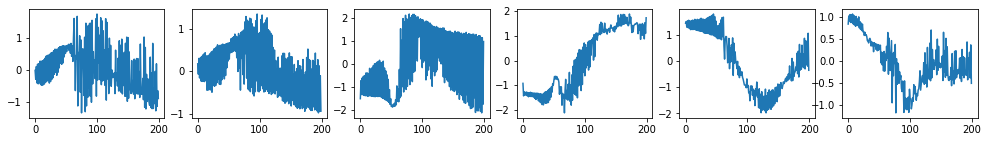

In [32]:
showMe(X[1])

In [65]:
#AUGMENT
noise = np.random.normal(0,0.1,X.size)
noise = np.reshape(noise,X.shape)

augmented = X + noise
X_aug = np.concatenate((X,augmented))
y_aug = np.concatenate((y,y))

print(X_aug.shape)
print(y_aug.shape)

(600, 6, 100)
(600, 3)


In [69]:
def get_dense_model():
    inspected_chanels= X.shape[1]
    signal_length=     X.shape[2]
    input_layer = keras.Input(shape = (inspected_chanels,signal_length), name='input')
    x = layers.Flatten()(input_layer)

    # x     = layers.Dense(1000)(x)
    # x     = layers.BatchNormalization()(x)

    l2 = 0.001
    x     = layers.Dense(300,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)


    x     = layers.Dense(100,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)



    x     = layers.Dense(70,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.Dropout(.2)(x)


    x     = layers.Dense(50,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)



    x     = layers.Dense(10,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.Dropout(.2)(x)


    output = layers.Dense(3, activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)

    #model.summary()
    return model

In [75]:
def get_hyper_model(hp):
    model = keras.Sequential()
    inspected_chanels= X.shape[1]
    signal_length=     X.shape[2]
    input_layer = keras.Input(shape = (inspected_chanels,signal_length), name='input')
    x = layers.Flatten()(input_layer)
    l2 = 0.001
    for i in range(hp.Choice('n_layers',[1,2,4,6])):
        x     = layers.Dense(hp.Int('dense',min_value=10,max_value=1000,sampling="log"),kernel_regularizer=regularizers.l2(l2))(x)
        x     = layers.BatchNormalization()(x)
        x     = layers.Dropout(hp.Choice('dropout',[0., 0.1,0.2]))(x)


    output = layers.Dense(3, activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)


    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log"),
        decay_steps=batch_size*10,
        decay_rate=hp.Choice('decay',[0.1,0.9]))

    #learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    #model.summary()
    return model

In [10]:
def get_model():
    inspected_chanels= X.shape[1]
    signal_length=     X.shape[2]
    input_layer = keras.Input(shape = (signal_length,inspected_chanels,1), name='input')
    x     = layers.Conv2D(64, kernel_size=(5,1), padding='same', activation='relu')(input_layer)
    x     = layers.Conv2D(32, kernel_size=(1,5), padding='same', activation='relu')(x)
    x     = layers.Conv2D(16, 16, padding='same', activation='relu')(x)
    x     = layers.Conv2D(8, 8, padding='same', activation='relu')(x)
    x     = layers.Conv2D(4, 4, padding='same', activation='relu')(x)
    x     = layers.GlobalAveragePooling2D()(x)
    x     = layers.Dense(8)(x)
    x     = layers.Dense(64)(x)
    output = layers.Dense(3, activation='softmax')(x)

    model = keras.Model(inputs=input_layer, outputs=output)

    #model.summary()
    return model

In [76]:

model = get_dense_model()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,
    decay_rate=0.1
    )

opt = keras.optimizers.SGD(learning_rate=lr_schedule) #, momentum=0.9, nesterov=True)
model.compile(optimizer=opt,
          loss='categorical_crossentropy',
          metrics=['accuracy']
         )
#model.summary()
#model.output

In [ ]:
skf = StratifiedKFold(n_splits=10)
tf.config.run_functions_eagerly(True)
accs = []
models = []
for train, test in skf.split(X_aug, y_aug.argmax(axis=1)):
  
    X_train = X_aug[train]
    X_test  = X_aug[test]
    y_train = y_aug[train]
    y_test  = y_aug[test]


    X_train = np.expand_dims(X_train, axis = -1) 
    X_test  = np.expand_dims(X_test,  axis = -1)

    batch_size = 30 #len(X_train)
    print("Batch size: {}".format(batch_size))

    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_test, y_test),
                        batch_size=batch_size,
                        epochs=50,
                        shuffle=True)

    showHistory(history)          
    acc = max(history.history['val_accuracy'])
    accs.append(acc)                       
    models.append(model)
    break
    if acc > 0.9:
        break


model = models[accs.index(max(accs))]
for acc in accs:
    print(acc)

In [77]:
skf = StratifiedKFold(n_splits=10)
tf.config.run_functions_eagerly(True)

for train, test in skf.split(X, y.argmax(1)):
  
    X_train = X[train]
    X_test  = X[test]
    y_train = y[train]
    y_test  = y[test]

    batch_size = 30 #len(X_train)
    print("Batch size: {}".format(batch_size))


    tuner = kt.tuners.RandomSearch(
        get_hyper_model,
        objective='val_accuracy',
        max_trials=100)

    tuner.search(   X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    epochs=100,
                    shuffle=True)

    best_model = tuner.get_best_models()[0]
                             
    break
   

Trial 100 Complete [00h 03m 33s]
val_accuracy: 0.7333333492279053

Best val_accuracy So Far: 0.8666666746139526
Total elapsed time: 02h 04m 24s
INFO:tensorflow:Oracle triggered exit


In [24]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
n_layers: 1
dense: 22
dropout: 0.2
lr: 0.0009359788534144154
decay: 0.1
Score: 0.9444444179534912
Trial summary
Hyperparameters:
n_layers: 6
dense: 760
dropout: 0.1
lr: 0.00038316979115832244
decay: 0.9
Score: 0.8888888955116272
Trial summary
Hyperparameters:
n_layers: 6
dense: 68
dropout: 0.1
lr: 0.0026619800162710925
decay: 0.9
Score: 0.8888888955116272
Trial summary
Hyperparameters:
n_layers: 6
dense: 292
dropout: 0.1
lr: 0.007578897916446779
decay: 0.9
Score: 0.8888888955116272
Trial summary
Hyperparameters:
n_layers: 6
dense: 43
dropout: 0.1
lr: 0.0001671064584501386
decay: 0.9
Score: 0.8888888955116272
Trial summary
Hyperparameters:
n_layers: 2
dense: 36
dropout: 0.1
lr: 0.0003309888334695231
decay: 0.9
Score: 0.8888888955116272
Trial summary
Hyperparameters:
n_layers: 4
dense: 816
dropout: 0.0
lr: 0.006006969118465886
decay: 0.1
Scor